# Regression Tree

A regression tree automatically selects important predictors and suggests trading rules. The predictor variables are one-day returns, five-day returns, five-day standard deviation and so on. The target variable is one-day future return. 
<BR>

<B>Create a regression tree</B>
1. Import stock data
1. Define predictor variables and a target variable
2. Split the data into train and test 
3. Create a regression tree model using the training data
4. Visualize the model

<B>Analyzing the performance</B><BR><BR>
Part I: Single leaf
1. Trading rule based on one leaf node with the highest expected value of a target variable
5. Compute performance in the train and test dataset

Part II: Full tree
1. Trading rule based on all the leaf node
5. Compute the performance in the train and test dataset

# Importing Libraries and Apple Data

In [33]:
import pandas as pd
import numpy as np
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate

import yfinance as yf
import warnings
warnings.simplefilter("ignore")

In [2]:
# Download Data
apple = yf.download('AAPL', start = '2009-01-01', end='2022-04-25')

apple.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.775246,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.892371,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.844665,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.783196,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.834879,673500800


In [3]:
# Check for NaN values
apple.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
# Drop column 'Adj Close'
apple.drop(columns='Adj Close', inplace=True)

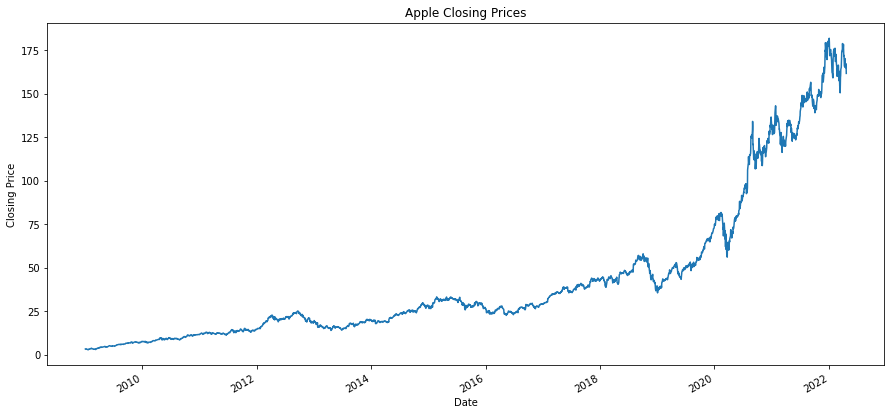

In [5]:
# Plotting Apple Closing Prices
apple['Close'].plot(label = 'AAPL', figsize=(15, 7))
plt.title('Apple Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

***

### Predictor variables and a target variable

Define a list of predictors from which the model will pick the best predictors. 

In [6]:
# Returns
apple['ret1'] = apple.Close.pct_change()

apple['ret5'] = apple.ret1.rolling(5).sum()
apple['ret10'] = apple.ret1.rolling(10).sum()
apple['ret20'] = apple.ret1.rolling(20).sum()
apple['ret40'] = apple.ret1.rolling(40).sum()

# Standard Deviation
apple['std5'] = apple.ret1.rolling(5).std()
apple['std10'] = apple.ret1.rolling(10).std()
apple['std20'] = apple.ret1.rolling(20).std()
apple['std40'] = apple.ret1.rolling(40).std()

#Technical Indicators
apple['ATR'] = ta.ATR(apple['High'], apple['Low'], apple['Close'], timeperiod= 14)
apple['EMA_30'] = ta.EMA(apple['Close'], timeperiod= 30)
apple['SMA_30'] = ta.SMA(apple['Close'], timeperiod = 30)

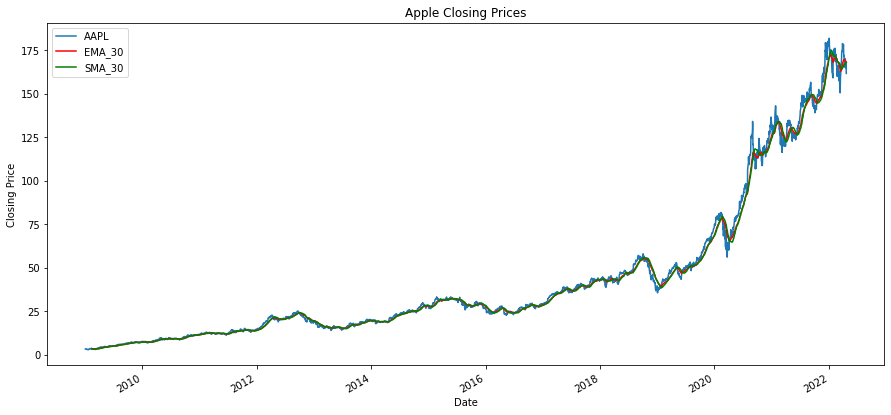

In [7]:
# Plotting Apple Closing Prices
apple['Close'].plot(label = 'AAPL', figsize=(15, 7))
apple['EMA_30'].plot(label = 'EMA_30', color='r')
apple['SMA_30'].plot(label = 'SMA_30', color = 'g')

plt.legend()
plt.title('Apple Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

***The target variable which is the future one-day returns of Apple stock***

In [8]:
# Shift -1 will moe the values backwards by 1
apple['retFut1'] = apple['ret1'].shift(-1)

In [9]:
# Drop the NaN values and store the variables
apple = apple.dropna()

predictor = ['ret1', 'ret5', 'ret10', 'ret20', 'ret40', 'std5', 'std10', 'std20', 'std40', 'ATR', 'EMA_30', 'SMA_30']
X = apple[predictor]
y = apple['retFut1']

### Split the data into train and test dataset
In order to verify if the regression tree model created is any good the data has to be split into two parts, first 75% of the dataset will be used to create the model and the remaining 25% will be used as a test dataset.

In [21]:
train_len = int(len(apple) * .75)

X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

### Create regression tree model

The DecisionTreeRegressor from sklearn.tree is used to create the tree model. The min_samples_leaf will first be set to 400. Further tuning of the model will come after the initial testing.

#### Min_Samples_Leaf = 400

In [11]:
# Regression Model
dtr = tree.DecisionTreeRegressor(min_samples_leaf=400)

# Fit the model on train data
dtr.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=400)

### Visualize the model

Visualize the regression tree created using the graphviz and sklearn's tree package.

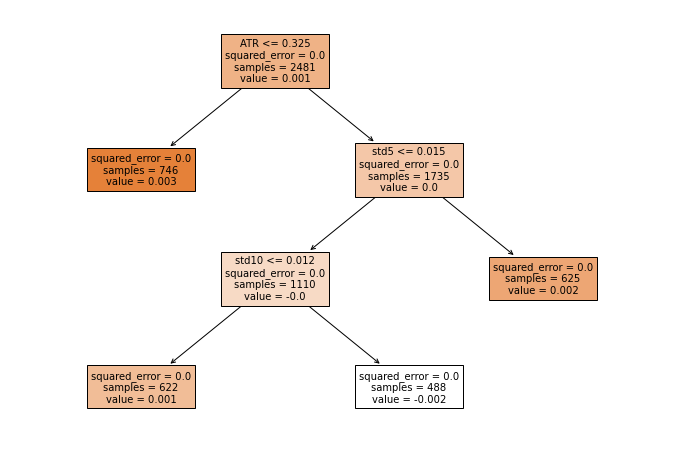

In [12]:
plt.figure(figsize=(12,8))
tree.plot_tree(dtr, filled=True, fontsize=10, feature_names=predictor)
plt.show()

### Trading rule based on the leaf node with the highest target variable value
The rule can be paraphrased as when ATR > 0.326 and std5 > 0.0155  then buy, else do not buy. So predicted_signal is '1' when buying and '0' otherwise. 

In [13]:
apple['predicted_signal'] = np.where(
    ((apple['ATR'] > .326) & (apple['std5'] > 0.0155)), 1, 0)

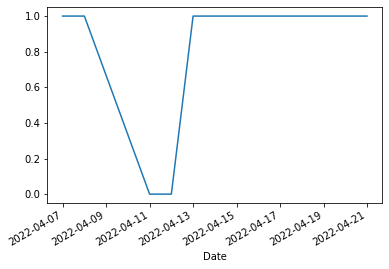

In [14]:
# Visualizing the signal predicted for last 20 days
apple.predicted_signal[-10:].plot()
plt.show()

The above graph shows the signal predicted for last 20 days. The strategy returns are generated by multiplying the future returns by the predicted signal and stored in the strategy_returns.

In [15]:
apple['strategy_returns_single_leaf'] = apple.retFut1 * apple.predicted_signal

### Trading rule based on the full tree

Define a trading rule based on the expected response of every single leaf. If the expected value is positive then we buy Apple stock otherwise, we sell the stock.

In [16]:
apple['predicted_signal'] = np.where(dtr.predict(X) > 0, 1, -1)
apple['strategy_returns_full_tree'] = apple.retFut1 * apple.predicted_signal

*** 

### Performance for single leaf

#### Sharpe ratio 

***Represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred***

In [18]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

Calculate the Sharpe ratio for the strategy in train and test dataset. The risk-free rate is assumed to be 5% p.a.

In [22]:
# Sharpe ratio
# Train dataset
apple['excess_daily_strategy_return'] = apple.strategy_returns_single_leaf - 0.05/252

sharpe_train_single_leaf = annualized_sharpe_ratio(
    apple.excess_daily_strategy_return.iloc[:train_len])

# Test dataset
sharpe_test_single_leaf = annualized_sharpe_ratio(
    apple.excess_daily_strategy_return.iloc[train_len:])

### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and the number of days represent the total trading days.

In [23]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

In [25]:
# Single Leaf
# Train dataset
ret_train_single_leaf = CAGR(
    apple.strategy_returns_single_leaf.iloc[:train_len])
# Test dataset
ret_test_single_leaf = CAGR(
    apple.strategy_returns_single_leaf.iloc[train_len:])

***

### Performance for full tree

In [27]:
# Calculate Sharpe ratio

# Train dataset
apple['excess_daily_strategy_return'] = apple.strategy_returns_full_tree - 0.05/252
sharpe_train_full_tree = annualized_sharpe_ratio(
    apple.excess_daily_strategy_return.iloc[:train_len])

# Test dataset
sharpe_test_full_tree = annualized_sharpe_ratio(
    apple.excess_daily_strategy_return.iloc[train_len:])

In [29]:
# Calculate CAGR

# Train dataset
ret_train_full_tree = CAGR(apple.strategy_returns_full_tree.iloc[:train_len])

# Test dataset
ret_test_full_tree = CAGR(apple.strategy_returns_full_tree.iloc[train_len:])

***

### Performance Comparision of single leaf and full tree

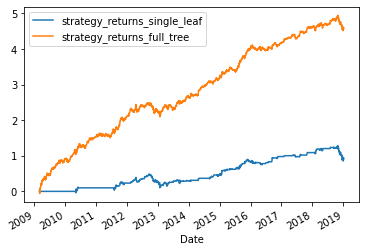

In [30]:
# Plot the cumulative returns for single leaf in train dataset
apple.strategy_returns_single_leaf[:train_len].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
apple.strategy_returns_full_tree[:train_len].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

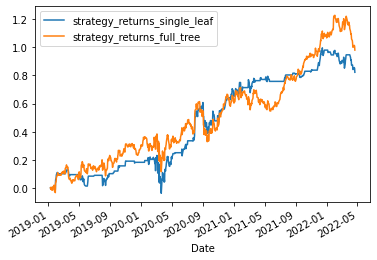

In [31]:
# Plot the cumulative returns for single leaf in train dataset
apple.strategy_returns_single_leaf[train_len:].cumsum().plot()

# Plot the cumulative returns for full tree in train dataset
apple.strategy_returns_full_tree[train_len:].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

In [34]:
# Tabulate the performance in train and test dataset for single leaf and a full tree
print(tabulate(
    [
        ['CAGR', ret_train_single_leaf, ret_train_full_tree,
         ret_test_single_leaf, ret_test_full_tree],
        ['Sharpe Ratio', sharpe_train_single_leaf, sharpe_train_full_tree,
         sharpe_test_single_leaf, sharpe_test_full_tree],
    ],
    headers=['Train (Single Leaf)', 'Train (Full Tree)',
             'Test (Single Leaf)',  'Test (Full Tree)'],
    tablefmt='orgtbl'))

|              |   Train (Single Leaf) |   Train (Full Tree) |   Test (Single Leaf) |   Test (Full Tree) |
|--------------+-----------------------+---------------------+----------------------+--------------------|
| CAGR         |              6.91685  |            19.1154  |            20.0204   |          23.0821   |
| Sharpe Ratio |              0.285955 |             1.58553 |             0.713882 |           0.742107 |


***

### Trade Details and Strategy Analytics

In [35]:
def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    trades = pd.DataFrame()
    current_position = 0
    entry_time = ''

    for i in data.index:

        new_position = data.loc[i, signal_column]

        if new_position != current_position:    

            if entry_time != '':                   
                entry_price = data.loc[entry_time, close_column]
                exit_time = i
                exit_price = data.loc[exit_time, close_column]
                trade_details = pd.DataFrame([(current_position,entry_time, entry_price, exit_time,exit_price)])
                trades = trades.append(trade_details,ignore_index=True)  
                entry_time = ''            

            if new_position != 0:
                entry_time = i
            current_position = new_position


    trades.columns = ['Position','Entry Time','Entry Price','Exit Time','Exit Price']
    trades['PnL'] = (trades['Exit Price'] - trades['Entry Price']) * trades['Position']
    return trades

def get_analytics(trades):
    """Function to generate strategy analytics
    """

    analytics = pd.DataFrame(index=['Strategy'])
    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position==1])
    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position==-1])
    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + analytics.num_of_short
    
    # Gross Profit
    analytics['gross_profit'] = trades.loc[trades.PnL>0].PnL.sum()
    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL<0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[trades.PnL>0])
    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL<=0])
    # Win percentage
    analytics['win_percentage'] = 100*analytics.winners/analytics.total_trades
    # Loss percentage
    analytics['loss_percentage'] = 100*analytics.losers/analytics.total_trades
    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL>0].PnL.mean()
    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL<=0].PnL.mean()

    return analytics.T

In [38]:
trades = get_trades(apple, 'Close', 'predicted_signal')
print('Trade Details')
trades.head()

Trade Details


,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,1,2009-03-03,3.156071,2010-05-19,8.869286,5.713215
1,-1,2010-05-19,8.869286,2010-05-20,8.491429,0.377856
2,1,2010-05-20,8.491429,2010-06-02,9.426786,0.935357
3,-1,2010-06-02,9.426786,2010-06-04,9.141429,0.285357
4,1,2010-06-04,9.141429,2011-08-17,13.587143,4.445714


***

## Visualise the Entry and Exit

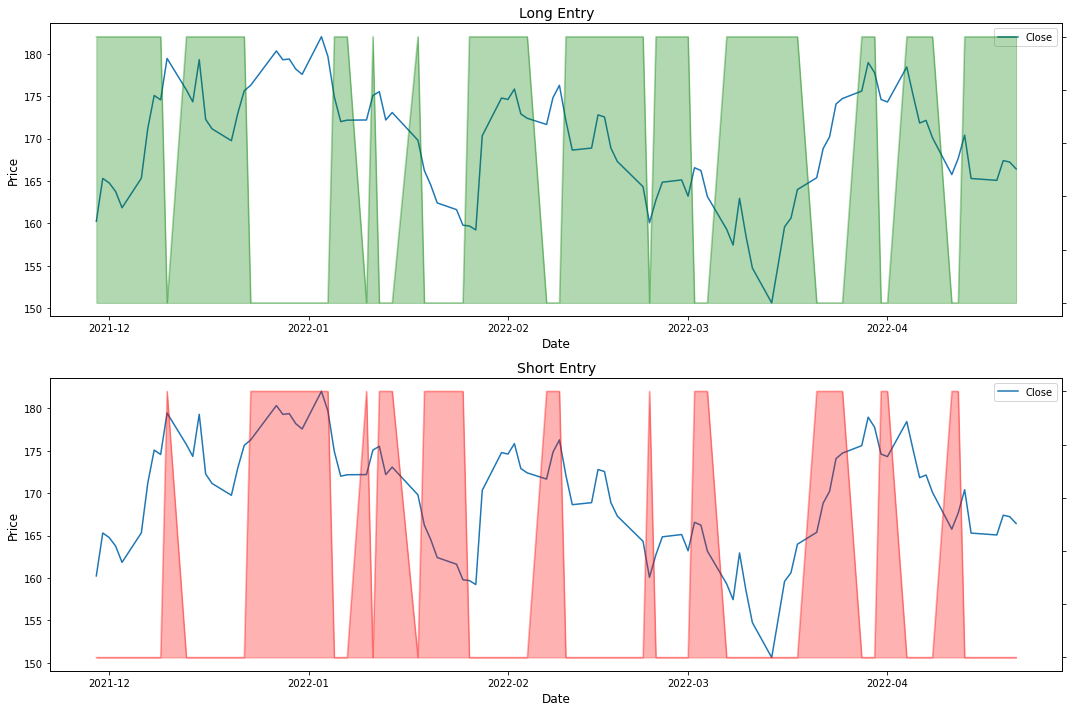

In [39]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Showing the last 100 points for illustration purpose
data_for_plot = apple[-100:]
data_for_plot['long_entry'] = data_for_plot.predicted_signal == 1
data_for_plot['short_entry'] = data_for_plot.predicted_signal == -1

fig = plt.figure(figsize=(15, 10))

# Sub plot for the long position
ax = fig.add_subplot(211)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')

# Set the title and axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()

# Plot the time where the long position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(data_for_plot['long_entry'].index,
                 data_for_plot['long_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')


# Set the title and axis labels
ax.set_title('Short Entry', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()

# Plot the time where the short position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(data_for_plot['short_entry'].index,
                 data_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

In [40]:
analytics = get_analytics(trades)
print('Strategy Analytics')
round(analytics,2)

Strategy Analytics


,Strategy
num_of_long,217.00
num_of_short,217.00
total_trades,434.00
gross_profit,471.26
gross_loss,-295.70
net_profit,175.56
winners,256.00
losers,178.00
win_percentage,58.99
loss_percentage,41.01


Start date,2009-03-04
End date,2022-04-21
Total months,157
,Backtest
Annual return,47.2%
Cumulative returns,15919.3%
Annual volatility,28.2%
Sharpe ratio,1.51
Calmar ratio,1.31
Stability,0.96
Max drawdown,-36.0%


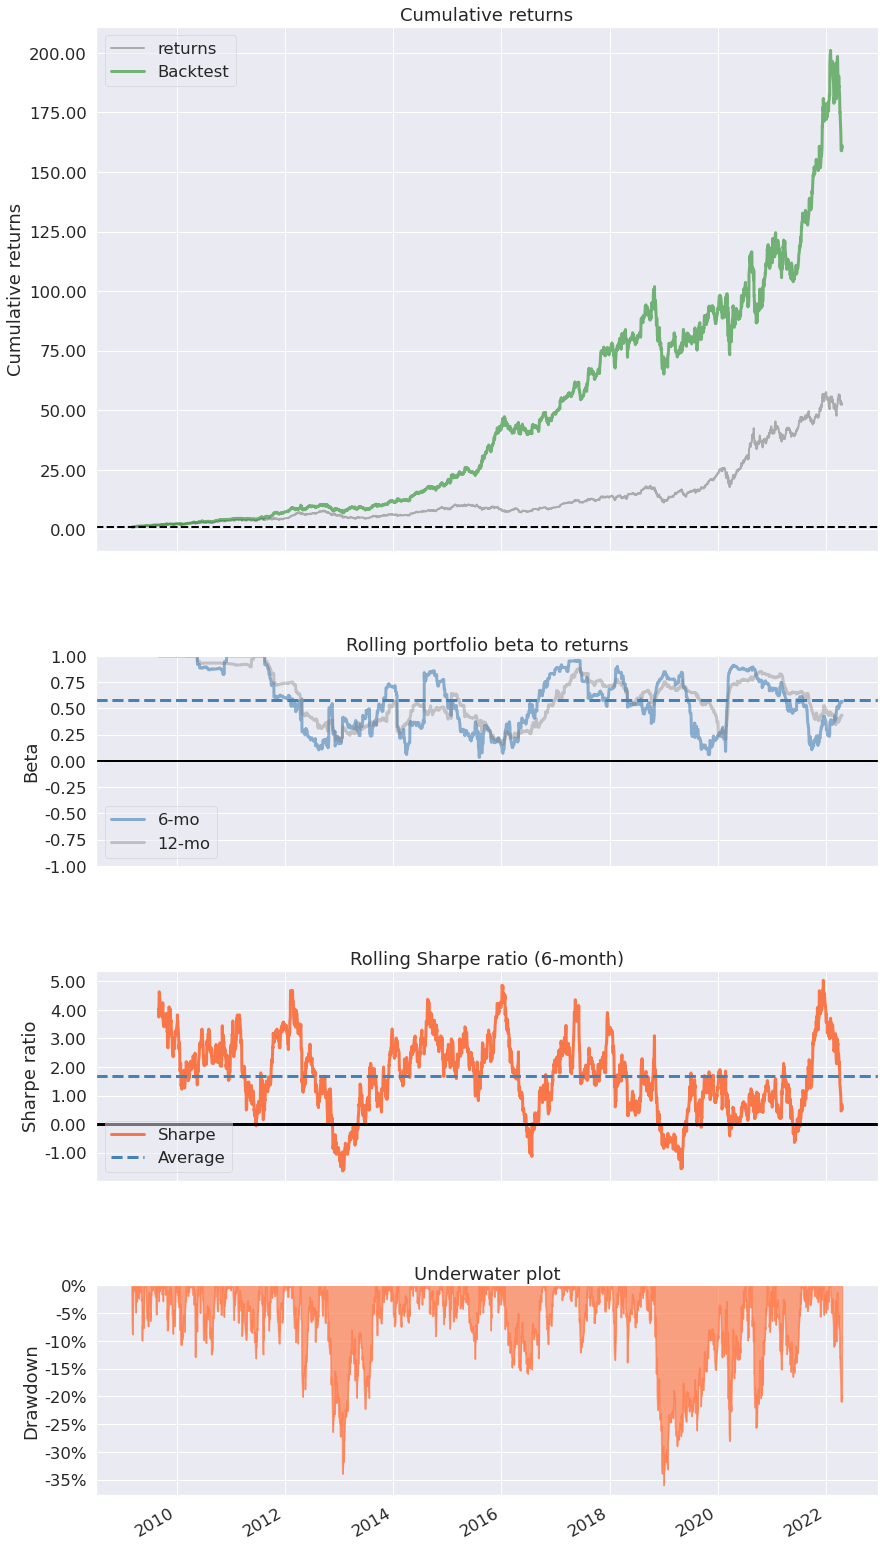

In [43]:
import pyfolio as pf
import warnings
warnings.filterwarnings("ignore")

apple['returns'] = apple.Close.pct_change()
apple['strategy_returns'] = apple['returns'] * apple['predicted_signal'].shift(1)
apple = apple.dropna()
pf.create_simple_tear_sheet(apple['strategy_returns'],benchmark_rets=apple['returns']) 

***

In [54]:
# Import numpy
import numpy as np

# Import talib
import talib as ta

# Import machine learning libraries
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as sm

# Import blueshift libraries
from blueshift.api import(
                            symbol,
                            order_target_percent,
                            schedule_function,
                            date_rules,
                            time_rules,
                            get_datetime
                        )


def initialize(context):

    # Define symbol
    context.security = symbol('AAPL')

    # Lookback to fetch data
    context.lookback = 200

    # The train-test split
    context.split_percentage = 0.8

    # Variable to store train and test dataset
    context.X_train = None
    context.X_test = None
    context.y_train = None
    context.y_test = None

    # The flag variable used to check whether to retrain the model or not
    context.retrain_flag = True

    # The variable to store the classifier
    context.dtr = None

    context.position = 0

    # Schedule the retrain_model function every month
    schedule_function(
        retrain_model,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

    # Schedule the rebalance function to run daily at market close
    schedule_function(
        rebalance,
        date_rule=date_rules.every_day(),
        time_rule=time_rules.market_close()
    )


def retrain_model(context, data):
    """
        A function to retrain the  model. This function is called by
        the schedule_function in the initialize function.
    """
    context.retrain_flag = True


def rebalance(context, data):
    try:
        data = data.history(
            context.security,
            ['open', 'high', 'low', 'close', 'volume'],
            context.lookback,
            '1d')
    except IndexError:
        return

    # Create predictor variables and a target variable

    # Returns
    data['ret1'] = data.close.pct_change()
    data['ret5'] = data.ret1.rolling(5).sum()
    data['ret10'] = data.ret1.rolling(10).sum()
    data['ret20'] = data.ret1.rolling(20).sum()
    data['ret40'] = data.ret1.rolling(40).sum()

    # Standard Deviation
    data['std5'] = data.ret1.rolling(5).std()
    data['std10'] = data.ret1.rolling(10).std()
    data['std20'] = data.ret1.rolling(20).std()
    data['std40'] = data.ret1.rolling(40).std()

    data['retFut1'] = data.ret1.shift(-1)

    #Technical Indicators
    data['ATR'] = ta.ATR(data['high'], data['low'], data['close'], timeperiod= 14)
    data['EMA_30'] = ta.EMA(data['close'], timeperiod= 30)
    data['SMA_30'] = ta.SMA(data['close'], timeperiod = 30)   
    # Drop NAN values
    data = data.dropna()

    # Store all predictor variables in a variable X
    predictor_list = ['ret1', 'ret5', 'ret10', 'ret20', 'ret40', 'std5', 'std10', 'std20', 'std40', 'ATR', 'EMA_30', 'SMA_30']
    X = data[predictor_list]   

    if context.retrain_flag:
        context.retrain_flag = False

        # Store target variable in y
        y = data.retFut1

        # Split the data into train and test dataset
        train_length = int(context.split_percentage*len(X))

        context.X_train = X[:train_length]
        context.X_test = X[train_length:]
        context.y_train = y[:train_length]
        context.y_test = y[train_length:]
        
        # Create regression tree model
        context.dtr = DecisionTreeRegressor(min_samples_leaf=400)
        context.dtr.fit(context.X_train, context.y_train)

    # Mean squared error
    mse = sm.mean_squared_error(context.y_test, context.dtr.predict(context.X_test))
    
    # Predicted Signal
    data['predicted_signal'] = context.dtr.predict(X)

    print("{} MSE: {}, Prediction: {}".format(
        get_datetime(), mse, data['predicted_signal'][-1]))

     # Place the orders
    if mse < 0.0005:
        if data['predicted_signal'][-1] > 0:
            order_target_percent(context.security, 1)
        elif data['predicted_signal'][-1] < 0:
            order_target_percent(context.security, -1)
        else:
            order_target_percent(context.security, 0)
    else:
        order_target_percent(context.security, 0)

ModuleNotFoundError: No module named 'blueshift'

***Backtesting results on Github Readme***